# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import torch.nn as nn
from torch.autograd import Variable
from detection_output import Detect
from prior_box import PriorBox
from l2norm import L2norm as L2norm
from utils import*
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import PIL
from PIL import Image
from f_l2norm import L2norm as norm
from model import build_ssd
import torch.backends.cudnn as cudnn
from multibox_loss import MultiBoxLoss

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC 2007 dataset  

In [2]:
net = build_ssd('test', 300, 21)    # initialize SSD

net.load_weights('weights/VOC.t7')  # load weights by specifying location of .t7 file 

Loading lua model weights...
0 Copying data from
  nn.SpatialConvolution(3 -> 64, 3x3, 1, 1, 1, 1) to
  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Copying data from
  nn.SpatialConvolution(64 -> 64, 3x3, 1, 1, 1, 1) to
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Copying data from
  nn.SpatialConvolution(64 -> 128, 3x3, 1, 1, 1, 1) to
  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Copying data from
  nn.SpatialConvolution(128 -> 128, 3x3, 1, 1, 1, 1) to
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 Copying data from
  nn.SpatialConvolution(128 -> 256, 3x3, 1, 1, 1, 1) to
  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 Copying data from
  nn.SpatialConvolution(256 -> 256, 3x3, 1, 1, 1, 1) to
  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 Copying data from
  nn.SpatialConvolution(256 -> 256, 3x3, 1, 1, 1, 1) to
  Conv2d(256, 256, kernel_si

## Load Image 
### Here we just load an example image provided in the data folder

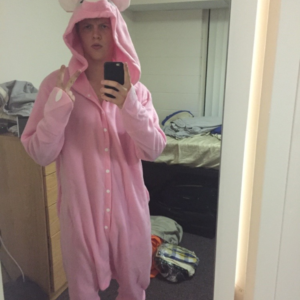

In [4]:
img = load_lua('data/img9505.t7')
image = Image.open('./data/IMG_9505.jpg').convert('RGB') 
# Using the torchvision package, we can create a Compose of multiple 
# built-in transorm ops to apply 
t = transforms.Compose([
        transforms.Scale(300),
        transforms.CenterCrop(300),

    ])
# View the transformed input image 
t(image) 

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [5]:
x = img.float()
x = Variable(x) # wrap tensor in Variable
y = net(x)      # forward pass 

## Parse the Detections
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

In [6]:
from voc import VOC_CLASSES as labelmap
import numpy as np
def get_labelname(labelmap, top_label_indices):
    names = []
    for l in top_label_indices:
        names.append(labelmap[int(l)])
    return names

detections = y.data.numpy()
# Parse the outputs.
det_label = detections[0,:,1]
det_conf = detections[0,:,2]
det_xmin = detections[0,:,3]
det_ymin = detections[0,:,4]
det_xmax = detections[0,:,5]
det_ymax = detections[0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

## View Results 

In [7]:
import matplotlib.pyplot as plt

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(image)  # plot the image for matpltlib
currentAxis = plt.gca()
# scale each detection back up to the image
for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.size[0]))
    ymin = int(round(top_ymin[i] * image.size[1]))
    xmax = int(round(top_xmax[i] * image.size[0]))
    ymax = int(round(top_ymax[i] * image.size[1]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

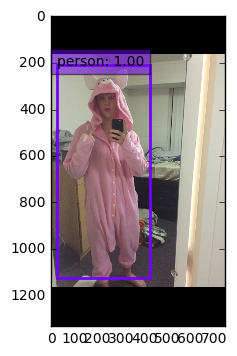

In [8]:
plt.show()  # display label, score, and bounding boxes!